<a href="https://colab.research.google.com/github/nourwalid70/Image-Segmentation/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy
import math
import os
import imageio
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import scipy.stats 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualization

In [ ]:
def visualize(img_path):
  path_img = 'drive/MyDrive/Colab Notebooks/Lab2/data/images/' + img_path + '.jpg'
  path_gt = 'drive/MyDrive/Colab Notebooks/Lab2/data/groundTruth/' + img_path + '.mat'
  #load original image
  img = plt.imread(path_img)
  print(type(img), img.shape)
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))
  ax.set_title('original image')
  ax.imshow(img)
  #load ground truth images
  gt = io.loadmat(path_gt)
  n = len(gt['groundTruth'][0])
  for i in range(n):
    gt_seg = gt['groundTruth'][0][i][0][0][0] * 255
    gt_boundries = gt['groundTruth'][0][i][0][0][1] * 255
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    #fig.suptitle('ground truth and')
    ax1.set_title('ground truth segmentation')
    ax1.imshow(gt_seg)
    ax2.set_title('ground truth boundaries')
    ax2.imshow(gt_boundries)
  print(gt_seg.shape)


<class 'numpy.ndarray'> (321, 481, 3)
(321, 481)


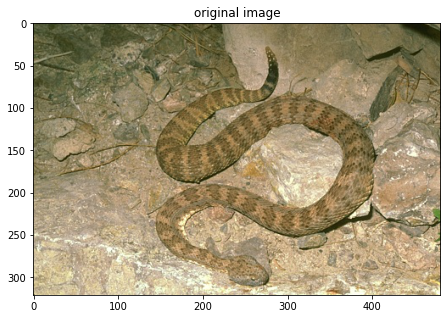

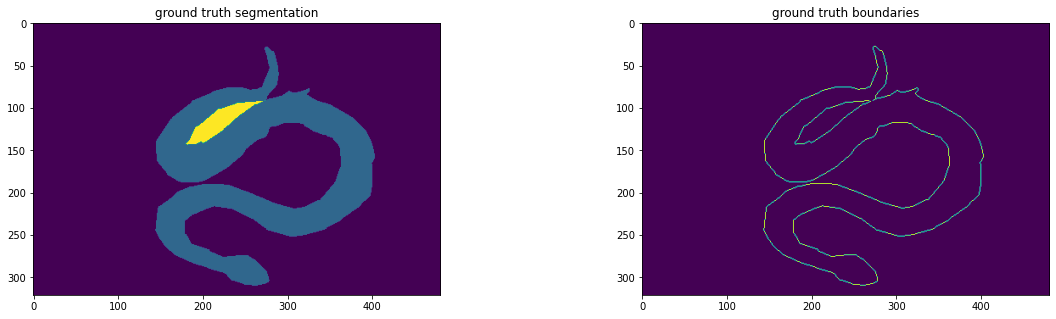

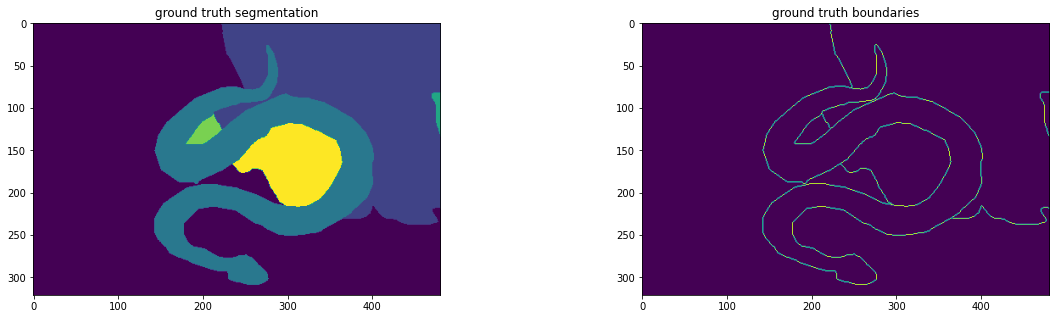

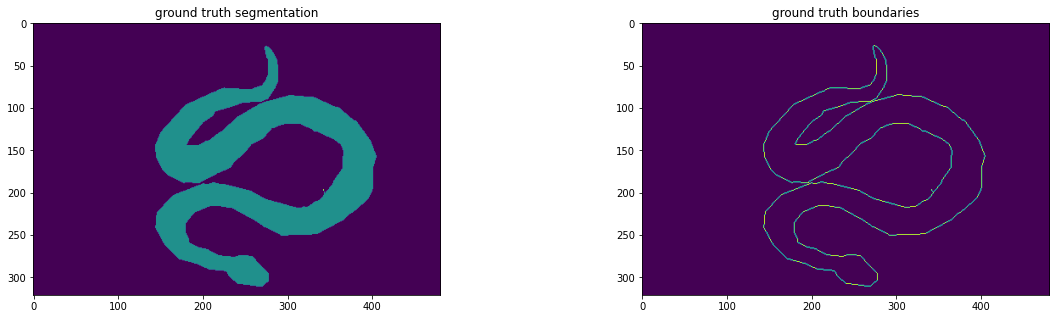

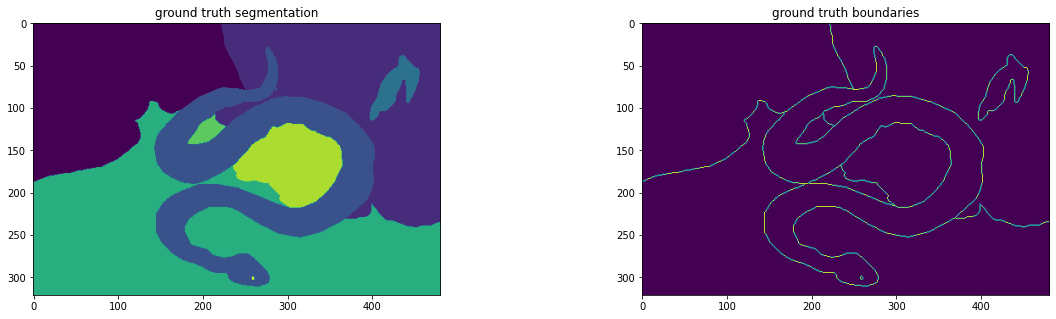

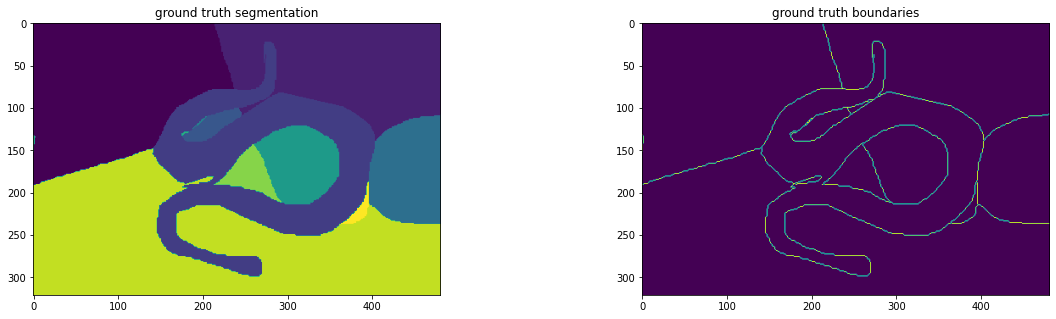

In [ ]:
visualize('test/87015')

# Clustering functions


In [ ]:
def read_img(img_path, include_xy=False):
  path_img ='drive/MyDrive/Colab Notebooks/Lab2/data/images/' + img_path + '.jpg'
  image = cv2.imread(path_img)
  # Change color to RGB (from BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  if include_xy:
    # Finding coordinates of each pixel
    indicesArray = np.moveaxis(np.indices(image.shape[:2]), 0, 2)
    # Reshaping the image into a 2D array of pixels (RGB + xy)
    data =  np.dstack([image, indicesArray*0.2]).reshape((-1, 5))
  else:
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    data = image.reshape((-1,3))

  return data, image.shape

In [ ]:
'''
1. choose initial random centroids
2. calculate distances to these centroids from all points
3. assign clusters
4. calc mean of each cluster
5. choose new centroids  --> repeat step 2 until convergence
'''

def cluster(data, k):
  eps = 1e-4
  max_itr = 100
  # pick k random samples to be initial centroids
  centroids = random.sample(list(data), k)
  for itr in range(max_itr):
    # calc distances
    dist = euclidean_distances(data,centroids)
    # assign clusters
    assignment = np.argmin(dist, axis=1)
    joined = np.hstack((data, np.array([assignment]).T))
    #update centroids
    diff = 0
    for i in range(k):
      # select samples of cluster i
      cluster = joined[joined[:, -1] == i, :]
      if len(cluster) == 0:
        continue
      # find mean point of cluster i
      mean = np.mean(cluster[:,:-1], axis = 0)
      # calculate the difference (euclidean distance) between the previous and new centroid
      diff = max(diff, np.linalg.norm(mean-centroids[i]))
      # update centroids
      centroids[i] = mean

    # check convergence
    if diff < eps:
      break

  return assignment


In [ ]:
def save_img(assignment,dim, img_path):
  path_img ='drive/MyDrive/Colab Notebooks/Lab2/data/' + img_path + '.jpg'
  plt.imshow(assignment.reshape((dim[0],dim[1])))
  plt.savefig(path_img)

# Evaluation functions

In [ ]:
'''
1. split clusters into separate groubs (assignments + ground truth)
2. find majority of each cluster
3. calc purity of each class (size of cluster, # majority inside cluster)
4. calc recall of each class (size of majority, # majority inside cluster)
5. calc f(i) of each cluster
6. calc avg of f(i) ((divide by # of clusters))
'''
# assignment and gt are 1 dimensional numpy arrays
def f_measure(assignment, gt):
  k = len(np.unique(assignment))
  joined = np.hstack((np.array([assignment]).T, np.array([gt]).T))
  overall_freq = np.bincount(gt)
  avg_f = 0
  for i in range(k):
      # select samples of cluster i
      cluster = joined[joined[:, 0] == i, :]
      # count elements frequency
      freq = np.bincount(cluster[:, 1])
      # find majority element
      majority_ele = freq.argmax()
      # find count of majority element
      majority_count = freq[majority_ele]
      # calc precision (purity)
      p = majority_count / len(cluster)
      # calc recall
      r = majority_count / overall_freq[majority_ele]
      # add to avg
      avg_f += (2*p*r)/(p+r)

  return avg_f / k
  

In [ ]:
'''
1. split clusters into separate groubs (assignments + ground truth)
2. find cluster size and frequency of each class inside the cluster
3. loop to calc entropy of cluster i
4. add to conditional entropy
'''
# assignment and gt are 1 dimensional numpy arrays
def entropy(assignment, gt):
  k = len(np.unique(assignment))
  joined = np.hstack((np.array([assignment]).T, np.array([gt]).T))
  cond_h = 0
  
  for i in range(0, k):
      # select samples of cluster i
      cluster = joined[joined[:, 0] == i, :]
      size = len(cluster)
      # count elements frequency
      unique, counts = np.unique(cluster[:, 1], return_counts=True)
      # calc cluster entropy
      h = 0
      for c in counts:
        h += (-c/size)*np.log2(c/size) 
      cond_h += (size/len(assignment))*h

  return cond_h

In [ ]:
def gt(img_path):
  path_gt = 'drive/MyDrive/Colab Notebooks/Lab2/data/groundTruth/' + img_path + '.mat'
  gt = io.loadmat(path_gt)
  n = len(gt['groundTruth'][0])
  gts = []
  for i in range(n):
    gt_seg = gt['groundTruth'][0][i][0][0][0].flatten()
    gts.append(gt_seg)
  return gts
    

In [ ]:
def evaluate(assignment,gts):
  m = len(gts)
  avg_f,avg_e = 0, 0
  for i in range(m):
    avg_f += f_measure(assignment,gts[i])
    avg_e += entropy(assignment,gts[i])
  
  avg_f /= m 
  avg_e /= m 
  return avg_f, avg_e

# Generating imeges

In [ ]:
directory = 'drive/MyDrive/Colab Notebooks/Lab2/data/'
seg_test = os.listdir(directory + 'images/test')[:50]
for filename in seg_test: 
    img_num = filename.replace(".jpg","")
    img_directory = directory + 'segmentation_test/' + img_num
    if not os.path.exists(img_directory):
      os.makedirs(img_directory)
    else:
      continue

    for k in [3,5,7,9,11]:
      img_data, dim = read_img('test/'+ img_num)
      assignment = cluster(img_data, k)
      save_img(assignment,dim,'segmentation_test/' + img_num + '/' + str(k))
      gts = gt('test/' + img_num)
      avg_f,avg_e = evaluate(assignment,gts)
      path_img = directory + 'segmentation_test/' + img_num + '/info.txt'
      with open(path_img, 'a') as f:
        f.writelines('\n'+ str(k) + " " + str(avg_f) + " " + str(avg_e))


    print(f'**************************{filename}******************************')

**************************8068.jpg******************************
**************************51084.jpg******************************
**************************225022.jpg******************************
**************************100039.jpg******************************
**************************2018.jpg******************************
**************************87015.jpg******************************
**************************130066.jpg******************************
**************************246009.jpg******************************
**************************157087.jpg******************************
**************************230098.jpg******************************
**************************3063.jpg******************************
**************************226060.jpg******************************
**************************145079.jpg******************************
**************************48025.jpg******************************
**************************220003.jpg******************************
****

-----------------------------------------------------------------------------

# Finding best K

In [ ]:
directory = 'drive/MyDrive/Colab Notebooks/Lab2/data/segmentation/'
dic_k_f = {3:0, 5:0, 7:0, 9:0, 11:0}
dic_k_e = {3:0, 5:0, 7:0, 9:0, 11:0}
for folder in os.listdir(directory): 
  info_path = directory + folder + '/info.txt'

  #finding best k for each image
  info_file = open(info_path, 'r')
  Lines = info_file.readlines()
  k_f, f, k_e, e = 0, 0, 0, 0
  Lines = Lines[1:]
  for line in Lines:
      l = line.split()
      if float(l[1]) > f: #update f
        k_f, f = float(l[0]), float(l[1])

      if float(l[2]) > e: #update e 
        k_e, e = float(l[0]), float(l[2])

  dic_k_f[k_f] += 1
  dic_k_e[k_e] += 1

best_k_f = max(dic_k_f, key=dic_k_f.get)
best_k_e = max(dic_k_e, key=dic_k_e.get)
print('best k for f-measure : ', best_k_f, ', best k for entropy with base = 2 : ', best_k_e)



best k for f-measure :  3 , best k for entropy with base = 2 :  3


# Running 50 test images

In [ ]:
directory = 'drive/MyDrive/Colab Notebooks/Lab2/data/'
images = os.listdir(directory + 'images/test')[:50]
print(len(images))
overall_avg_f, overall_avg_e = 0, 0
for filename in images: 
    img_num = filename.replace(".jpg","")
    k = 3
    img_data, dim = read_img('test/'+ img_num)
    assignment = cluster(img_data, k)
    gts = gt('test/' + img_num)
    avg_f, avg_e = evaluate(assignment,gts)
    overall_avg_f += avg_f
    overall_avg_e += avg_e
    print('image #', img_num, ', f-measure : ', avg_f, ', entropy : ', avg_e)

print('\n\n********** overall average f-measure : ', overall_avg_f/len(images) , '*************  overall average entropy : ', overall_avg_e/len(images), '***************')

50
image # 105027 , f-measure :  0.43907387116539465 , entropy :  0.8607935539309157
image # 8068 , f-measure :  0.8220811390283173 , entropy :  0.6592469757382446
image # 51084 , f-measure :  0.40848944624556116 , entropy :  3.0520016799360286
image # 225022 , f-measure :  0.6054700634124216 , entropy :  1.441554625137525
image # 100039 , f-measure :  0.505100601203366 , entropy :  2.082300194059344
image # 2018 , f-measure :  0.48595231892487745 , entropy :  1.9963851071022696
image # 87015 , f-measure :  0.4656070924886316 , entropy :  1.3519583303958915
image # 130066 , f-measure :  0.5210675921686277 , entropy :  1.7637565439228666
image # 246009 , f-measure :  0.4594384149130357 , entropy :  2.182111284216797
image # 157087 , f-measure :  0.4137677660653895 , entropy :  3.0161376246498994
image # 230098 , f-measure :  0.40313318430407524 , entropy :  2.7449855972203174
image # 3063 , f-measure :  0.7458425892147614 , entropy :  0.4179994694996389
image # 226060 , f-measure :  0.3

# Bonus

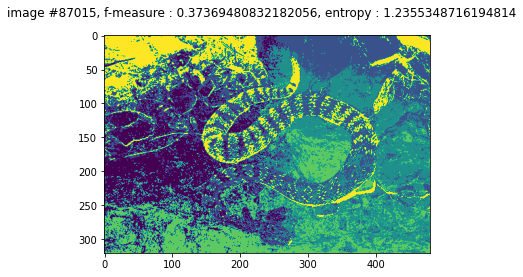

In [ ]:
k = 5
pics_index=["87015"]
for img_num in pics_index:
  img_data, dim = read_img('test/'+ img_num, True)
  assignment = cluster(img_data, k)
  gts = gt('test/' + img_num)
  avg_f, avg_e = evaluate(assignment,gts)
  plt.suptitle('image #' + img_num + ', f-measure : '+ str(avg_f) + ', entropy : ' + str(avg_e))
  plt.imshow(assignment.reshape((dim[0],dim[1])))
  

# Normalized Cut

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<class 'numpy.ndarray'> (481, 321, 3)
(481, 321)
f_measure=0.2011920650827484,entropy=2.2113754894524424


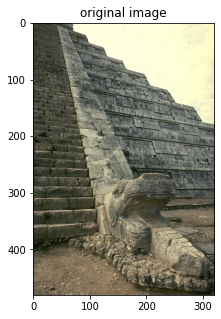

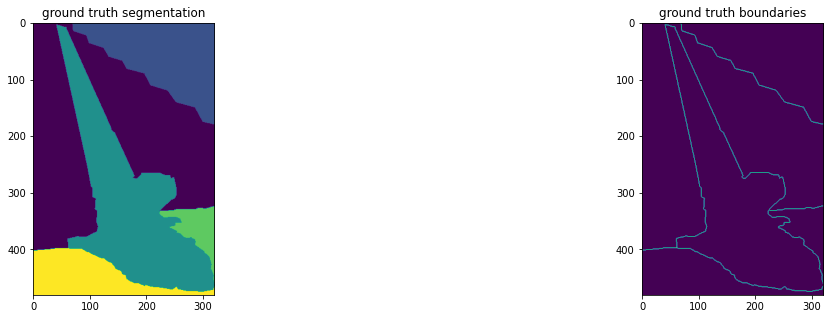

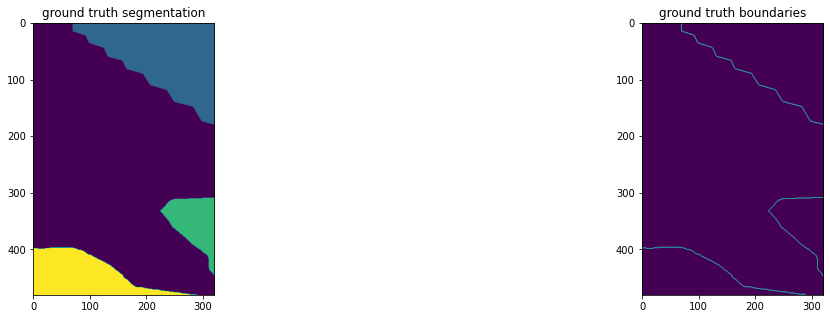

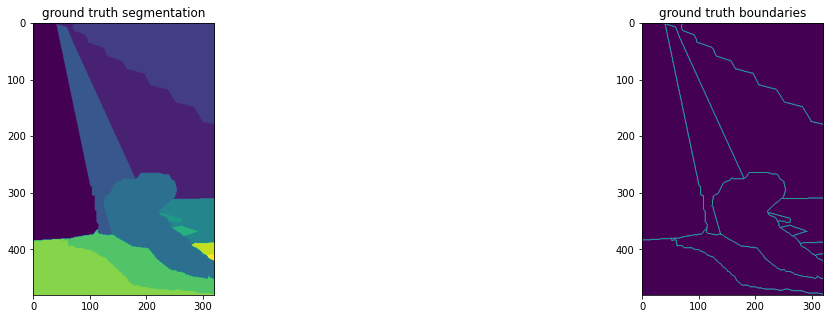

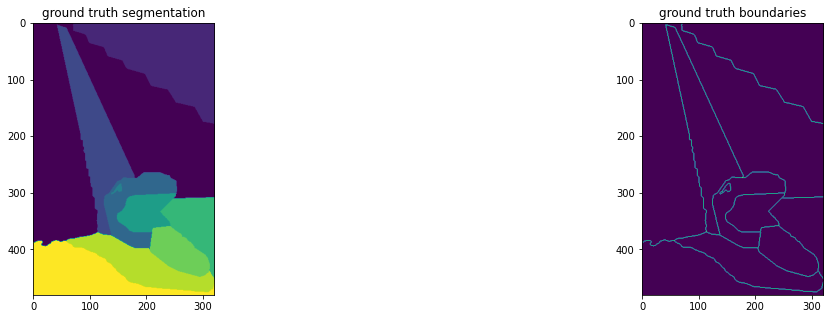

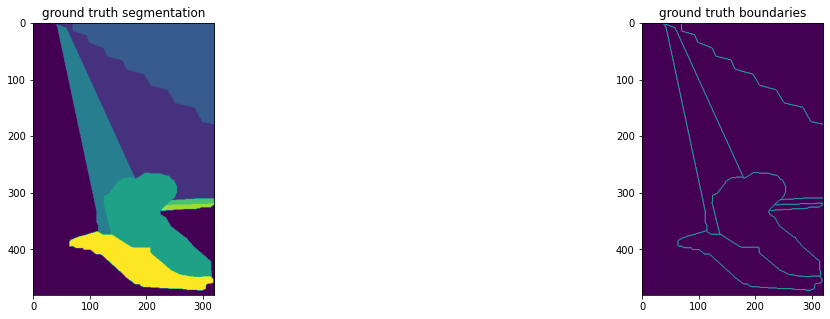

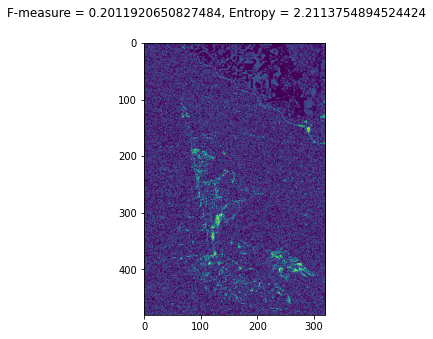

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<class 'numpy.ndarray'> (321, 481, 3)
(321, 481)
f_measure=0.2410474589789584,entropy=3.637532760713796


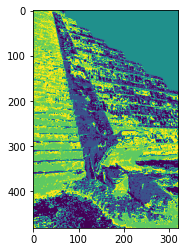

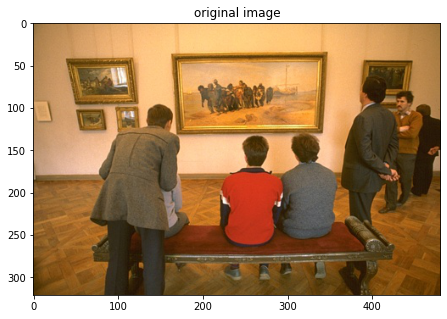

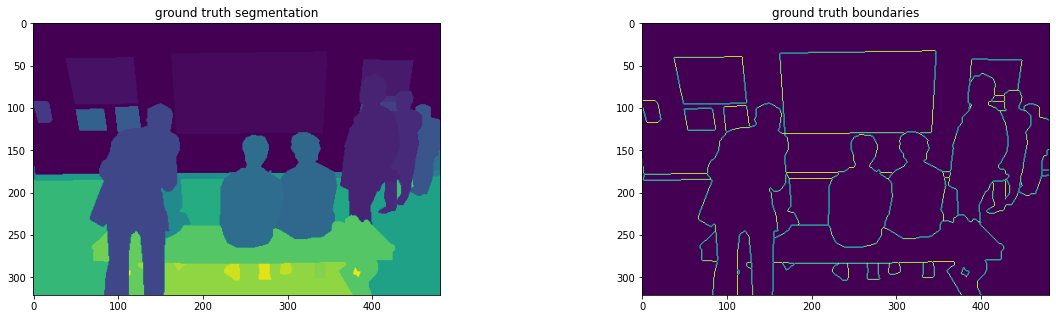

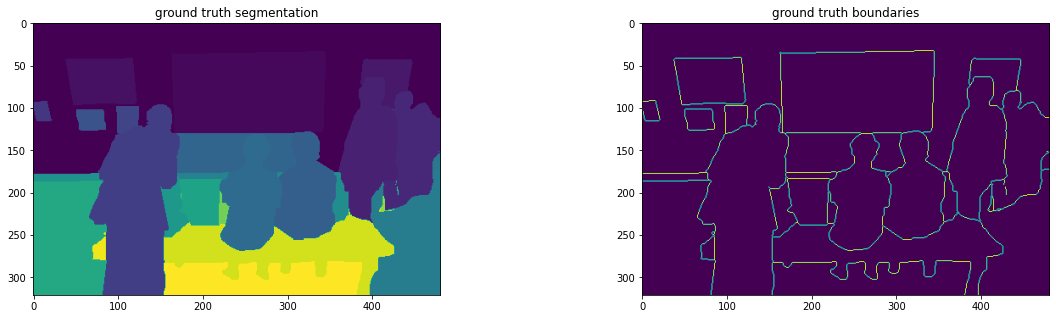

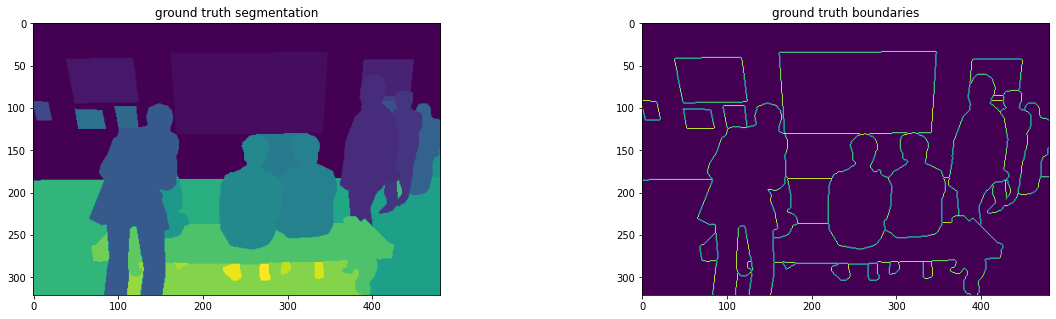

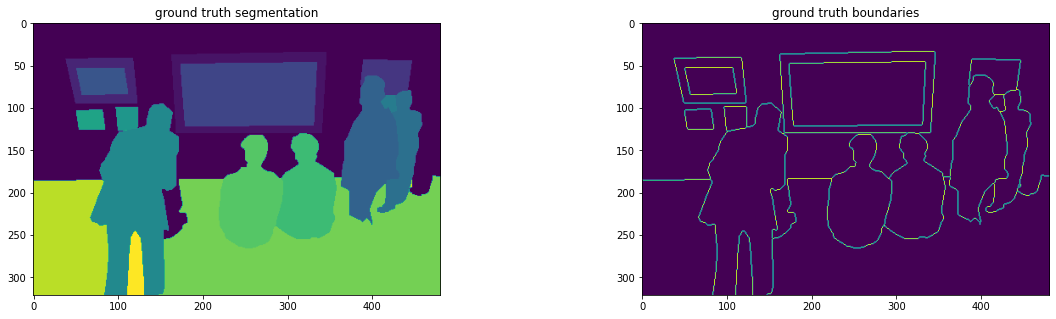

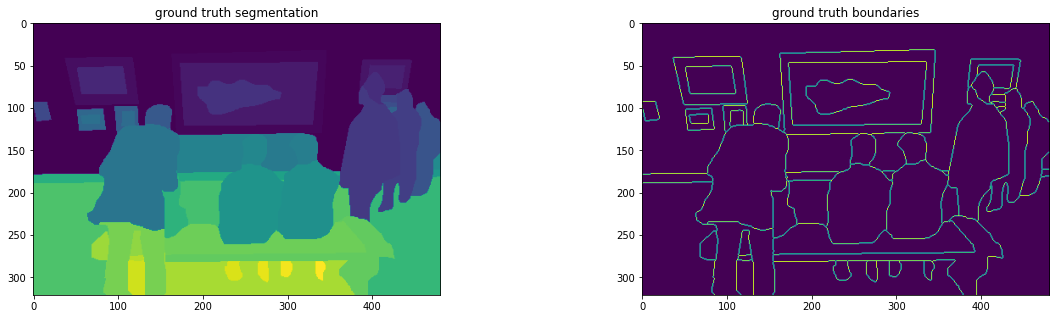

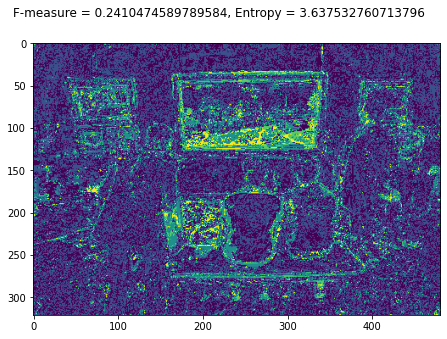

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<class 'numpy.ndarray'> (321, 481, 3)
(321, 481)
f_measure=0.22839762023893764,entropy=2.7181974888002123


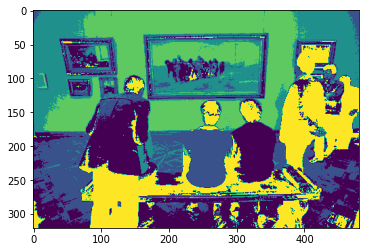

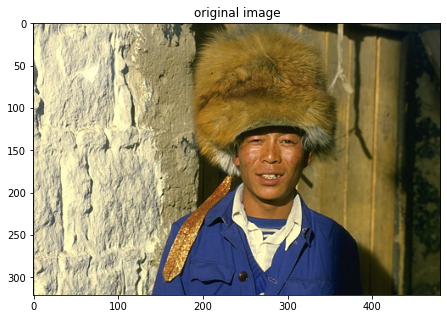

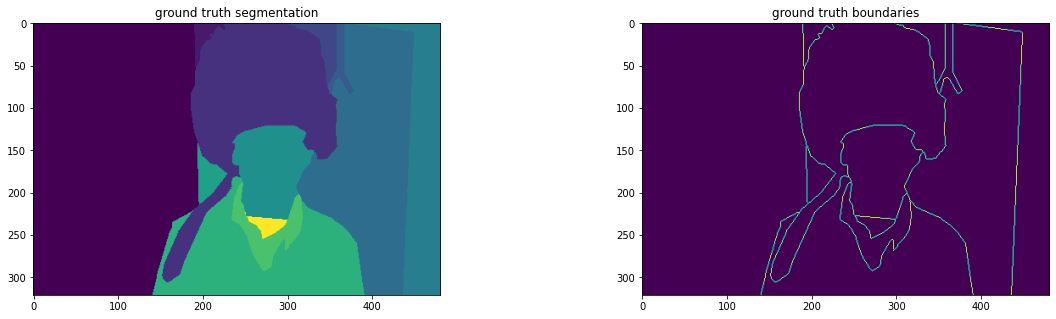

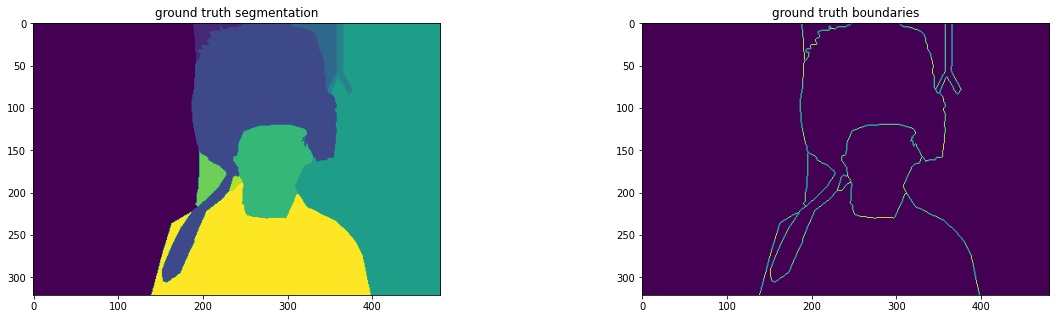

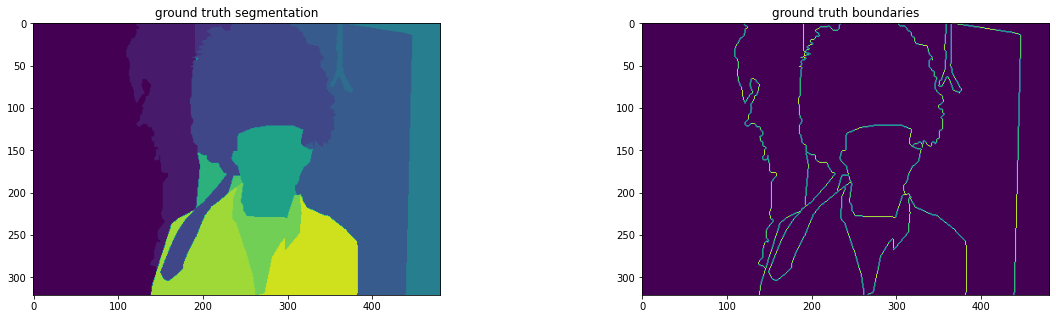

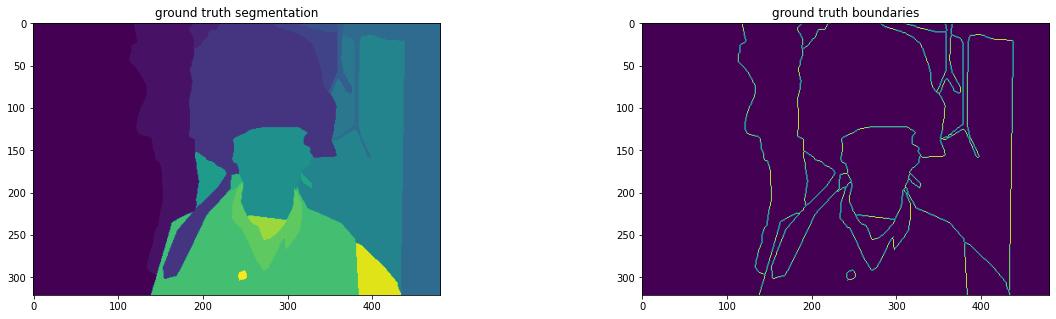

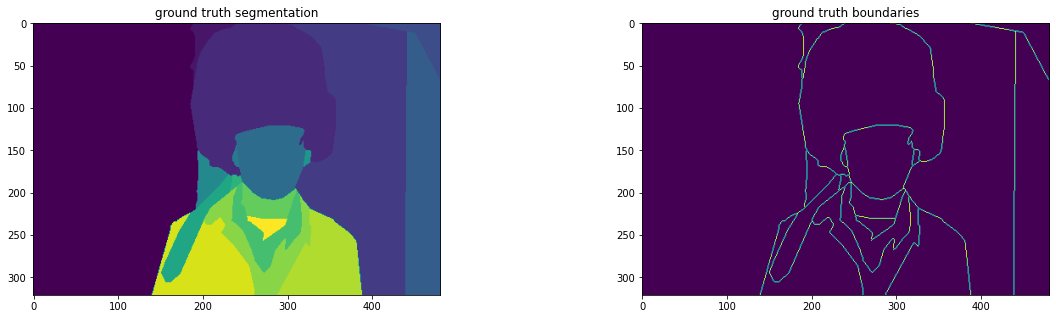

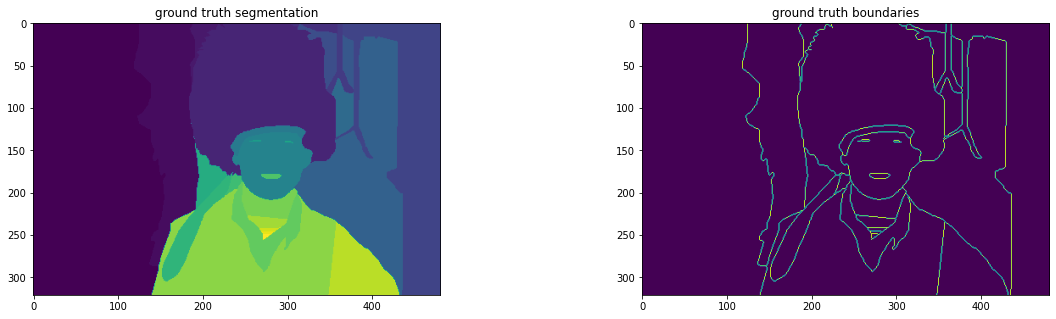

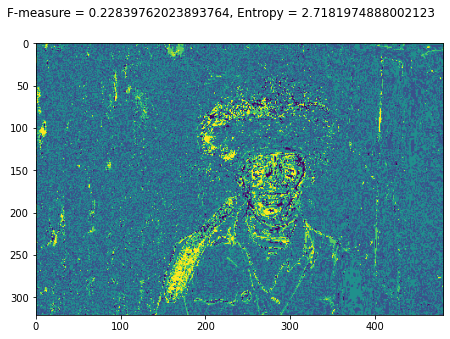

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<class 'numpy.ndarray'> (321, 481, 3)
(321, 481)
f_measure=0.26229590936670577,entropy=2.2983364649517073


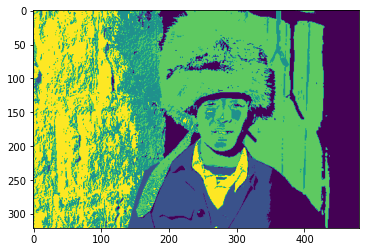

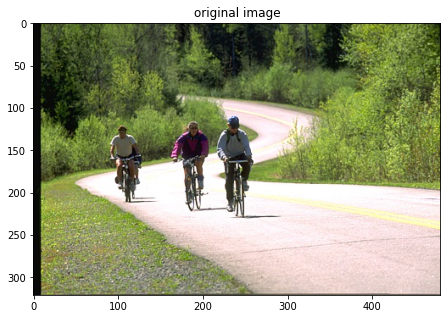

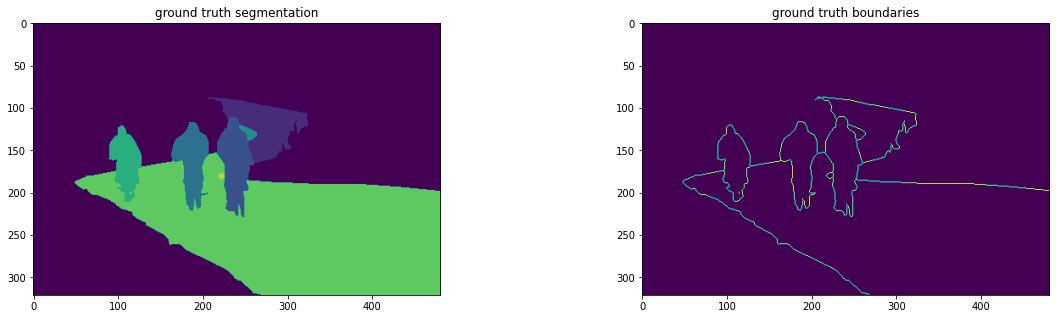

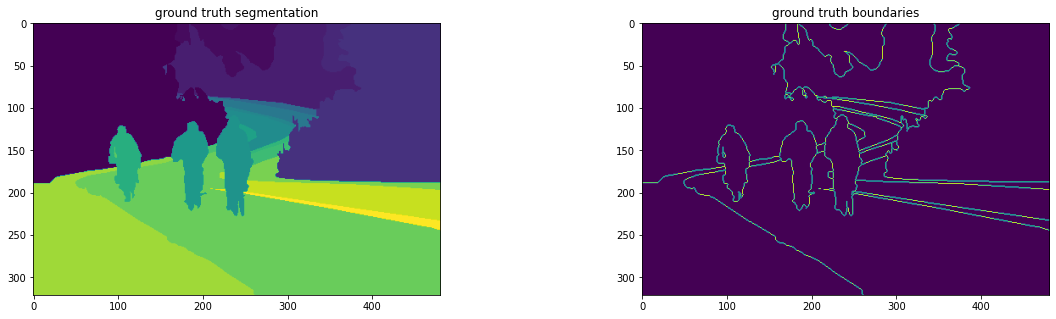

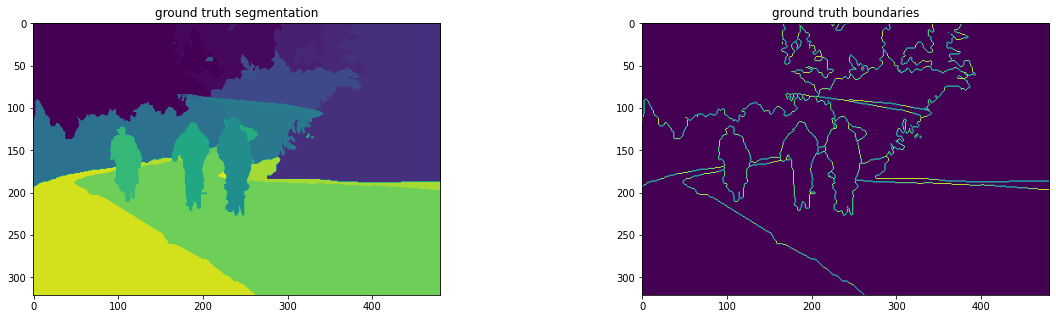

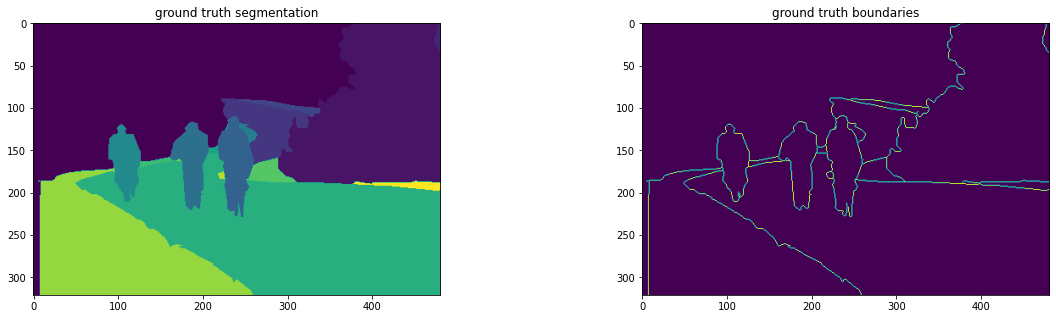

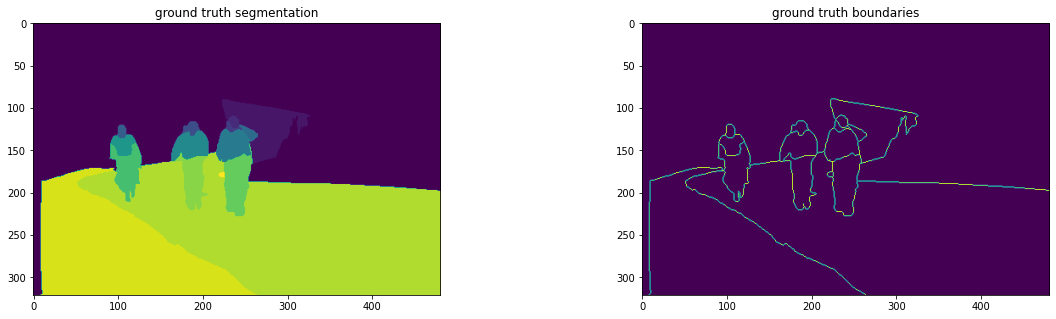

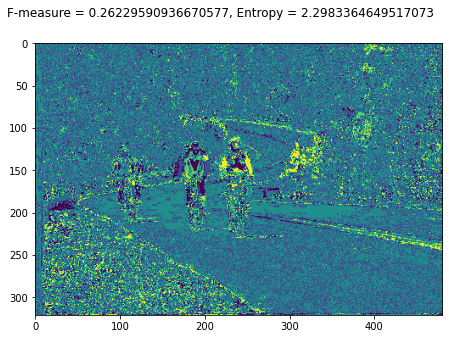

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<class 'numpy.ndarray'> (321, 481, 3)
(321, 481)
f_measure=0.22385715783940632,entropy=1.5614374245953662


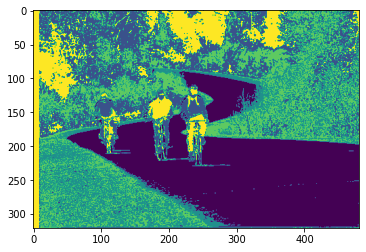

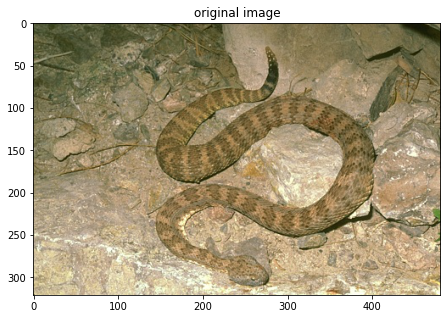

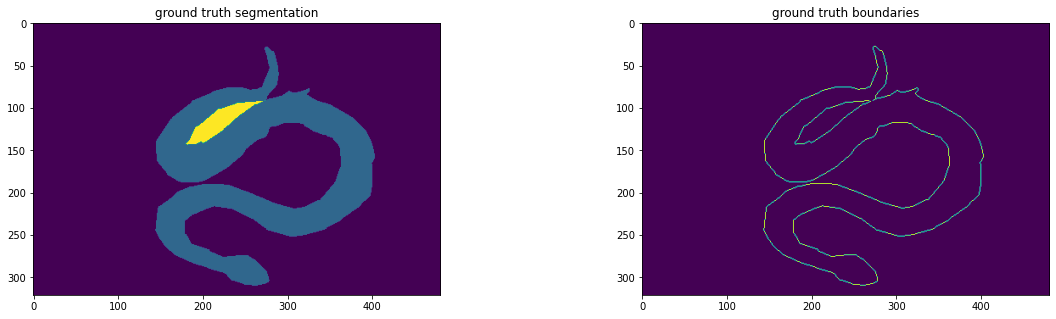

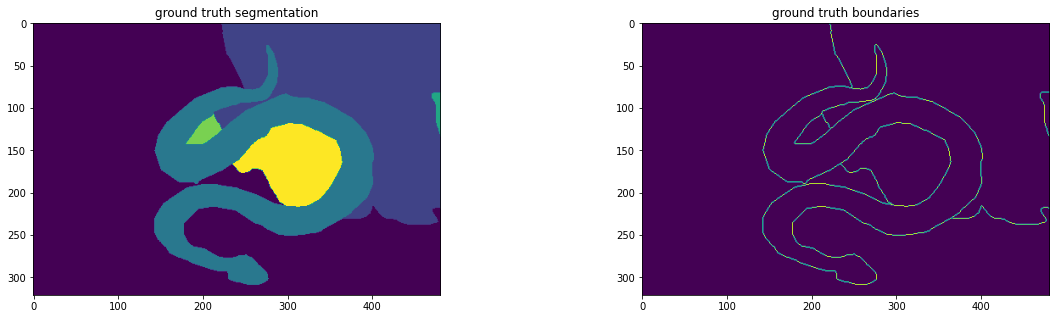

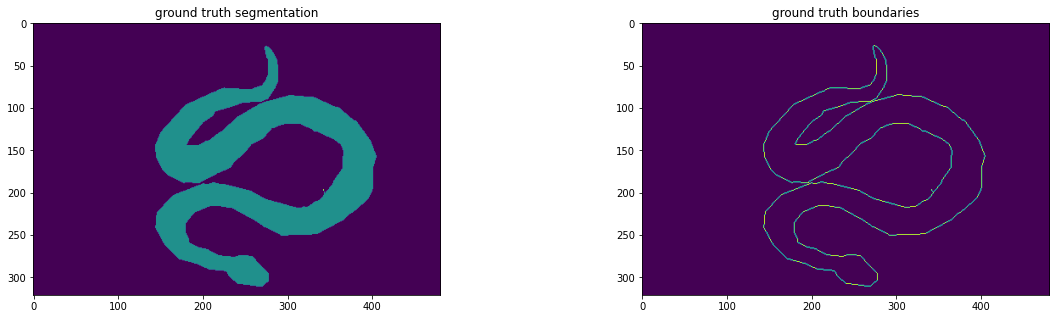

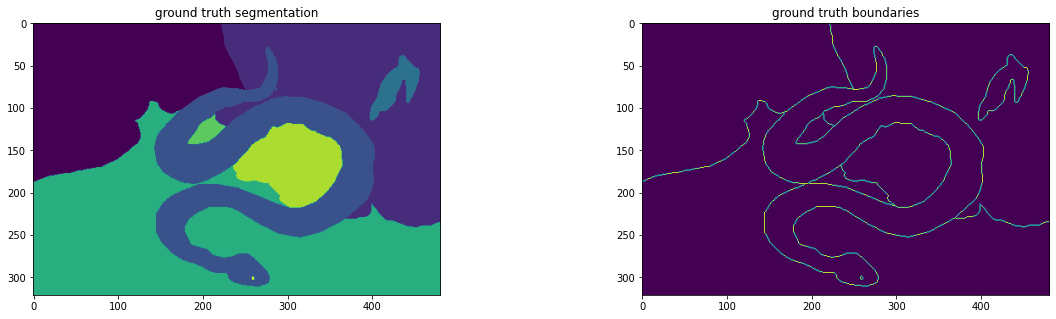

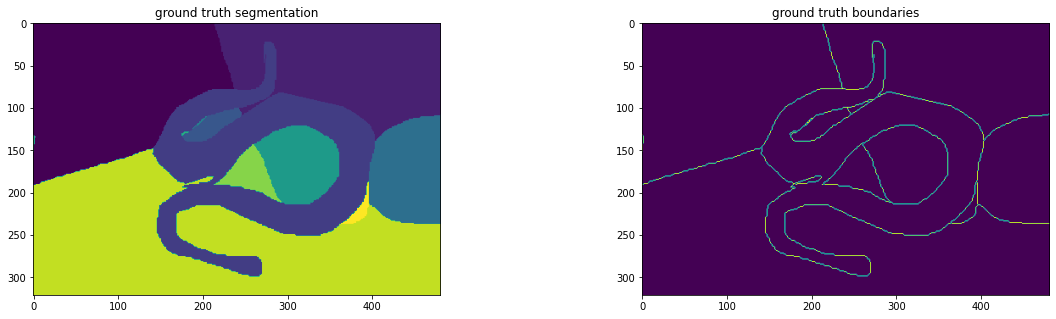

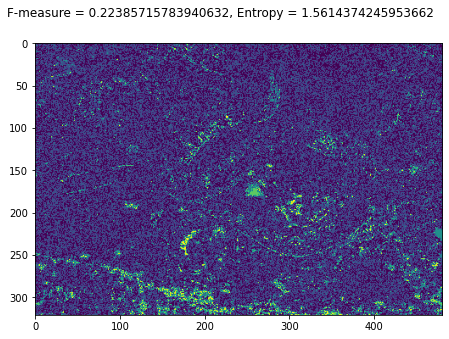

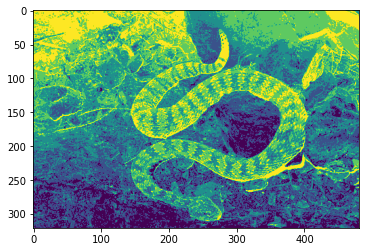

In [ ]:
from scipy import sparse
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh

pics_index=["33044","128035","15062","344010","87015"]
for i in range(len(pics_index)):
  image_path="test/"+pics_index[i]
  flat_image,dims=read_img(image_path)
  knnm=kneighbors_graph(flat_image,5)
  degrees1=knnm.sum(axis=1)
  degrees1=np.array(degrees1)
  delta_inv=1/degrees1
  delta_inv_mat=csr_matrix((154401,154401))
  delta_inv_mat.setdiag(delta_inv.T[0])
  delta_mat=csr_matrix((154401,154401))
  delta_mat.setdiag(degrees1.T[0])
  L=delta_mat-knnm
  aL=delta_inv_mat @ L
  eigen_values,eigen_vectors=eigsh(aL,k=5,which='SA')
  for j in range(len(eigen_vectors)):
     eigen_vectors[j]/=np.linalg.norm(eigen_vectors[j])
  assignment=KMeans(n_clusters=5,random_state=0)
  assignment=assignment.fit_predict(eigen_vectors)
  result=assignment.reshape((dims[0],dims[1]))
  visualize(image_path)
  fig, ax1 = plt.subplots(1, 1, figsize=(20, 5))
  gts=gt(image_path)
  f,e=evaluate(assignment,gts)
  print("f_measure={},entropy={}".format(f,e))
  ax1.set_label("f_measure={},entropy={}".format(f,e))
  plt.suptitle('F-measure = '+ str(f) + ', Entropy = ' + str(e))
  ax1.imshow(result)
  plt.show()
  a=cluster(flat_image,5)
  save_path='segmentation/'+image_path
  save_img(a,(dims[0],dims[1]),save_path)
  

